In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2


In [2]:
# model = coralme.io.json.load_json_me_model("../ACCELERATE/models/pputida-2024_05_20/KT2440-UPF36-DLKcat-Transport10.json")

### Load predictions

In [3]:
# fluxes = pandas.read_csv("./predictions/KT2440-UPF36-DLKcat-Transport10-R2A.csv",index_col=0)
# fluxes = pandas.read_csv("./predictions/KT2440-UPF36-DLKcat-Transport10-M9.csv",index_col=0)
fluxes = pandas.read_csv("./predictions/KT2440-UPF36-M9.csv",index_col=0)

In [4]:
pred = fluxes[fluxes.index.str.contains("translation_")]["fluxes"]*1e9
pred.name = "predicted"
pred.index = [r.split("translation_")[-1] for r in pred.index]

### Load omics data

In [32]:
rna = pandas.read_csv("./data-jul-2024/RNA-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [33]:
ribo = pandas.read_csv("./data-jul-2024/RS-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [138]:
samples = rna.columns.to_list()
rna_samples = [i + "_rna" for i in samples]
te_samples = [i + "_te" for i in samples]
all_samples = samples+rna_samples+te_samples+["predicted"]
colors = ["#2b83ba","#66bd63","#fdae61"]

### Load Annotation

In [38]:
def simplify(s):
    if isinstance(s,float):
        return s
    s = s.split("__")[-1]
    s = s.replace("S_","")
    s = s.replace("_"," ")
    s = s.replace("Metabolic:","")
    return s

In [186]:
Annotation = pandas.read_csv("./GeneAnnotation.csv",index_col=0).dropna(subset="subsystem")

In [187]:
Annotation["_subsystem"] = Annotation["subsystem"]
Annotation["subsystem"] = Annotation["subsystem"].apply(lambda x:simplify(x))

In [189]:
Annotation[Annotation["subsystem"]=="Biosynthesis"]

,locus_tag,name,description,type,length,subsystem,_subsystem
PP_0217,PP_RS01155,desA,delta-9 fatty acid desaturase DesA,CDS,1185.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_0558,PP_RS02945,accC,acetyl-CoA carboxylase biotin carboxylase subunit,CDS,1356.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_0559,PP_RS02950,accB,acetyl-CoA carboxylase biotin carboxyl carrier protein,CDS,462.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_0763,PP_RS04075,NaN,fatty acid--CoA ligase,CDS,1683.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_0922,PP_RS04850,NaN,ACP phosphodiesterase,CDS,585.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_1607,PP_RS08290,NaN,acetyl-CoA carboxylase carboxyltransferase subunit alpha,CDS,948.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_1913,PP_RS09855,fabD,ACP S-malonyltransferase,CDS,939.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_1916,PP_RS09870,fabF,beta-ketoacyl-ACP synthase II,CDS,1245.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_1996,PP_RS10355,accD,"acetyl-CoA carboxylase, carboxyltransferase subunit beta",CDS,894.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis
PP_2376,PP_RS12390,NaN,fatty acid cis/trans isomerase,CDS,2301.0,Biosynthesis,Metabolic:S_Fatty_Acid__Biosynthesis


### Combine results

In [174]:
NormalizedRibo = ribo.div(ribo.sum())*1e6
NormalizedRNA = rna.div(rna.sum())*1e6
NormalizedTE = NormalizedRibo.div(NormalizedRNA,axis=0)
Results = NormalizedRibo.join(NormalizedRNA,rsuffix="_rna").join(NormalizedTE,rsuffix="_te").join(pred)
ResultsAnnotated = pandas.concat([Results,Annotation],axis=1).loc[Results.index]
ResultsAnnotated.head()

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna,PPutida_1_te,PPutida_2_te,PPutida_4_te,predicted,locus_tag,name,description,type,length,subsystem,old_subsystem
PP_0001,115.346129,101.379836,117.392753,0.428368,1.142857,1.386889,269.268957,88.707377,84.644676,NaN,PP_RS00005,NaN,ParB/RepB/Spo0J family partition protein,CDS,873.0,NaN,NaN
PP_0010,649.987487,654.840617,574.275588,0.870122,2.032432,1.871958,747.007359,322.195592,306.777985,NaN,PP_RS00050,dnaA,chromosomal replication initiator protein DnaA,CDS,1521.0,NaN,NaN
PP_0097,20.691063,14.890996,21.743415,0.053546,0.358301,0.321102,386.416850,41.560009,67.714909,NaN,PP_RS00495,NaN,YheV family putative zinc ribbon protein,CDS,282.0,NaN,NaN
PP_0947,32.817598,33.777137,39.853891,0.087012,0.129730,0.136639,377.160906,260.365490,291.672262,NaN,PP_RS04975,NaN,ZIP family metal transporter,CDS,894.0,NaN,NaN
PP_0948,14.117067,14.164606,29.334633,0.046853,0.098842,0.109311,301.307316,143.306005,268.358322,NaN,PP_RS04980,NaN,HPr family phosphocarrier protein,CDS,273.0,NaN,NaN


In [175]:
ResultsGrouped = ResultsAnnotated[all_samples+["subsystem"]].groupby("subsystem").sum()

###  Totals

In [97]:
RiboMeans = ResultsGrouped[samples].mean(axis=1).sort_values(ascending=False)
RNAMeans = ResultsGrouped[rna_samples].mean(axis=1).sort_values(ascending=False)

In [113]:
top = set(RiboMeans.head(10).index) | set(RNAMeans.head(10).index)
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
color_dct = {i:c for i,c in zip(top,colors)}

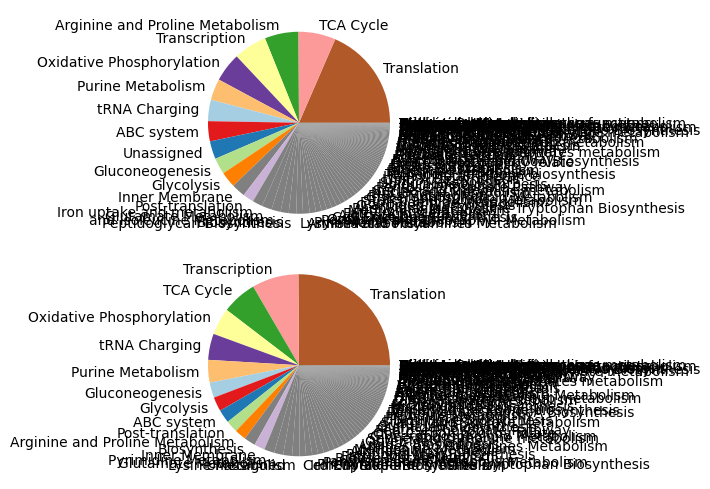

In [134]:
fig,ax = plt.subplots(2,1,figsize=(15,5))
RNAMeans.plot.pie(ax=ax[0],colors=[color_dct.get(i,"gray") for i in RNAMeans.index])
RiboMeans.plot.pie(ax=ax[1],colors=[color_dct.get(i,"gray") for i in RNAMeans.index])
fig.tight_layout()
fig.savefig("figures/ribo-rna-pathway-pie.svg",format="svg")

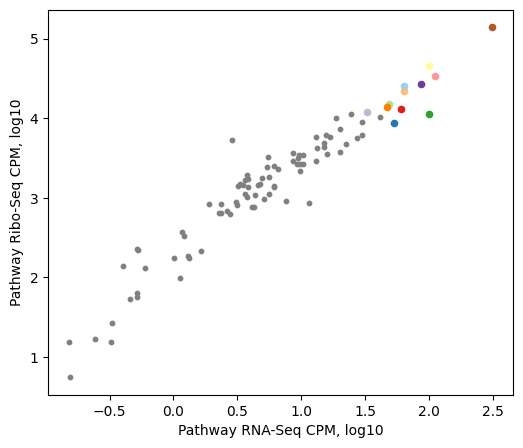

In [153]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
Means = pandas.concat([ResultsGrouped[samples].mean(axis=1).to_frame().rename(columns={0:"ribo"}),ResultsGrouped[rna_samples].mean(axis=1).to_frame().rename(columns={0:"rna"})],axis=1)
LogMeans = numpy.log10(Means)
# LogMeans.plot.scatter(x="rna",y="ribo",ax=ax)
for i,row in LogMeans.iterrows():
    s = 10
    if i in top:
        s = 20
    ax.scatter(x=row["rna"],y=row["ribo"],marker="o",s=s,color=color_dct.get(i,"gray"))
plt.xlabel("Pathway RNA-Seq CPM, log10")
plt.ylabel("Pathway Ribo-Seq CPM, log10")
fig.savefig("figures/ribo-rna-pathway-scatter.svg",format="svg")

### Correlation

In [141]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from scipy import stats
from scipy.stats import pearsonr

PearsonRResult(statistic=0.898918572275603, pvalue=4.547567266255022e-57)


/home/jt/venvs/coralme/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


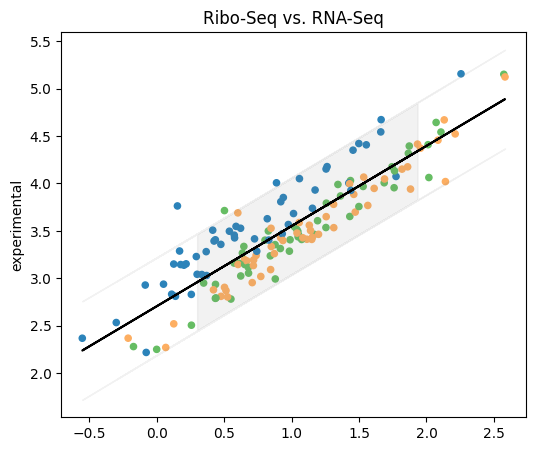

In [167]:
slist = samples
tmp = numpy.log10(ResultsGrouped).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
# colors = ["brown","blue","green"]
X = tmp[rna_samples].stack().values
y = tmp[slist].stack().values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
fig,ax = plt.subplots(1,1,figsize=(6,5))
colors = ["#2b83ba","#66bd63","#fdae61"]
for i,row in tmp.iterrows():
    ax.scatter(x=row[rna_samples],y=row[samples],marker="o",s=s,color=colors)
plt.plot(X,est2.predict(),color="black")
plt.ylabel("experimental")
print(pearsonr(numpy.squeeze(y),numpy.squeeze(est2.predict().reshape(-1,1))))


# Confidence interval
st, data, ss2 = summary_table(est2, alpha=0.05)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T
ax.fill_between(X,predict_ci_low,predict_ci_upp,color="gray",alpha=0.1)
plt.title("Ribo-Seq vs. RNA-Seq")

fig.savefig("figures/ribo-rna-pathway-correlation.svg",format="svg")